In [2]:
# HIDDEN

from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Lecture 31: Regression Inference ##

In [3]:
# HIDDEN

def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

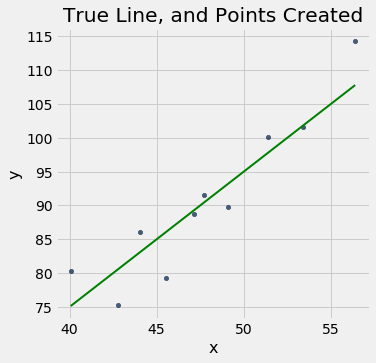

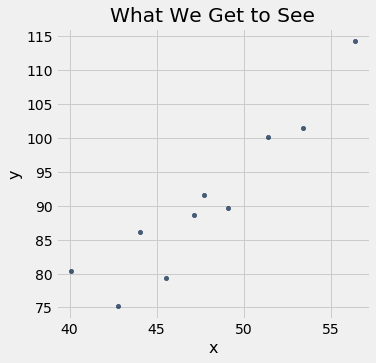

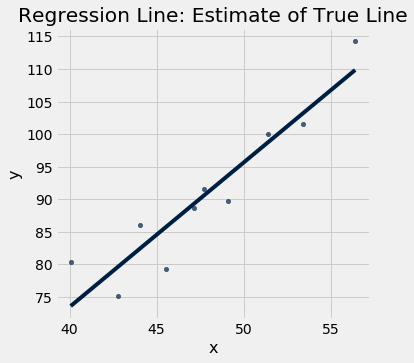

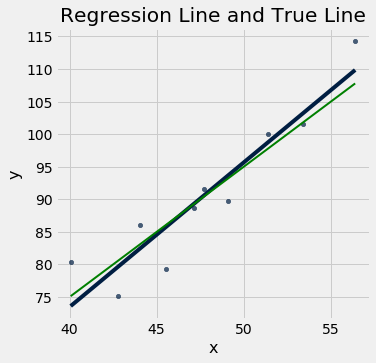

In [4]:
draw_and_compare(2, -5, 10)

## Prediction ##

In [16]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [17]:
def standard_units(any_numbers):
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, x, y):
    r = correlation(t, x, y)
    return r * np.std(t.column(y))/np.std(t.column(x))

def intercept(t, x, y):
    a = slope(t, x, y)
    return np.mean(t.column(y)) - a * np.mean(t.column(x))

def fitted_values(t, x, y):
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

def residuals(t, x, y):
    return table.column(y) - fit(t, x, y)

def prediction_at(t, x, y, value_of_x):
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * value_of_x + b

In [18]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

129.2129241703143

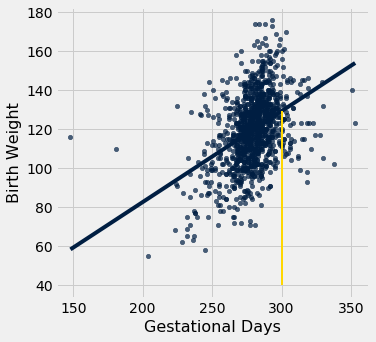

In [19]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='gold', lw=2);

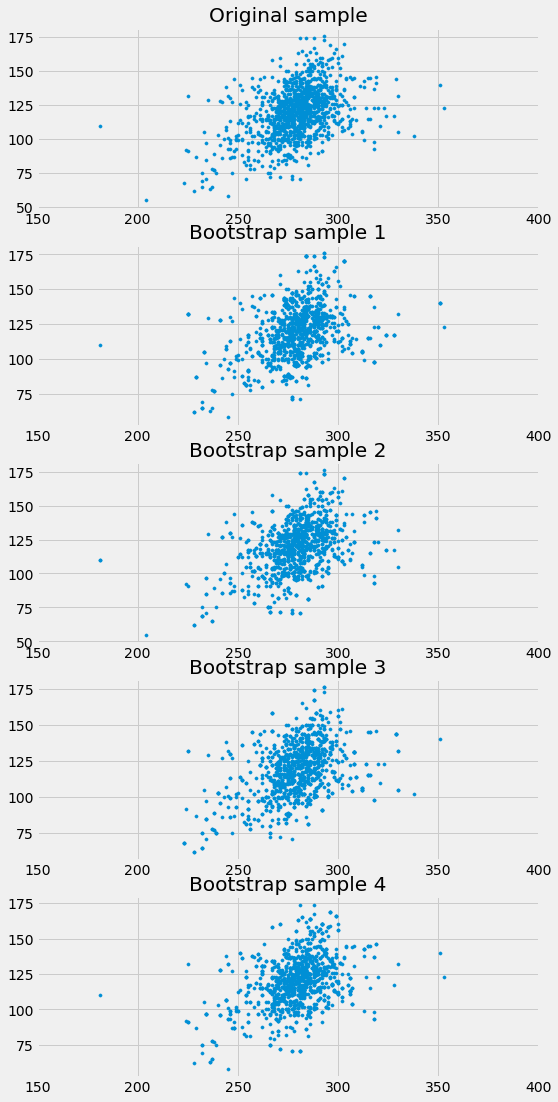

In [20]:
plots.figure(figsize=(8, 18))
plots.subplot(5, 1, 1)
plots.scatter(births[1], births[0], s=10)
plots.xlim([150, 400])
plots.title('Original sample')

for i in np.arange(1, 5, 1):
    plots.subplot(5,1,i+1)
    rep = births.sample()
    plots.scatter(rep[1], rep[0], s=10)
    plots.xlim([150, 400])
    plots.title('Bootstrap sample '+str(i))

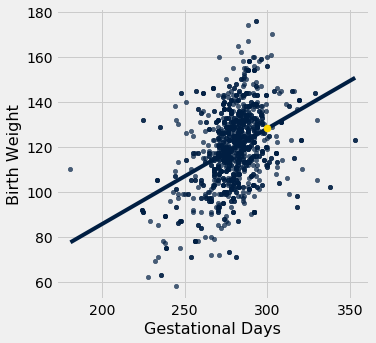

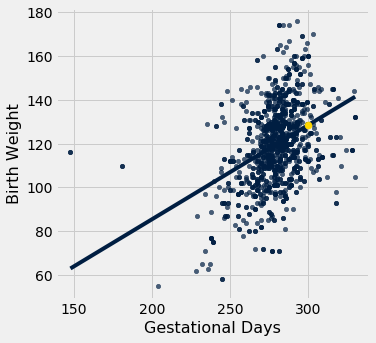

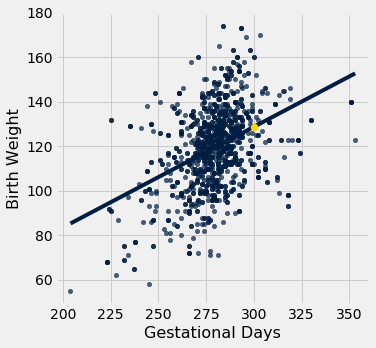

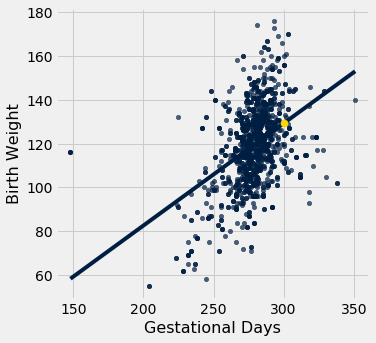

In [21]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);

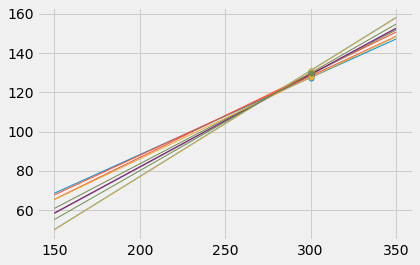

In [27]:
lines = Table(['slope','intercept', 'at 150', 'at 300', 'at 350'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 150 + b, a * 300 + b, a * 350 + b])
    
#births.scatter('Gestational Days', 'Birth Weight')
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([150, 350], [line.item('at 150'), line.item('at 350')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

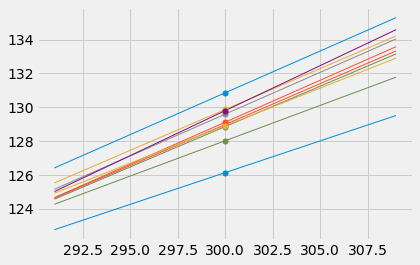

In [29]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

In [30]:
def bootstrap_prediction(t, x, y, new_x, repetitions=5000):

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions= np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')') 

Approximate 95%-confidence interval for height of true line:
127.21923556944087 131.2802347515479 (width = 4.0609991821070395 )


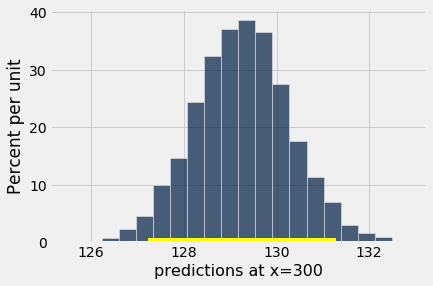

In [31]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

Approximate 95%-confidence interval for height of true line:
118.89106963260228 120.83151162589797 (width = 1.9404419932956927 )


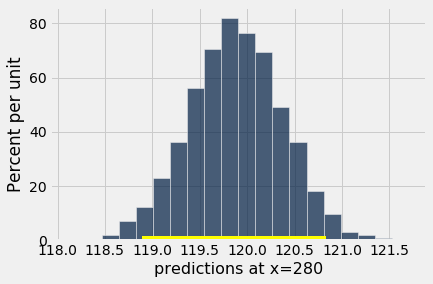

In [32]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

In [33]:
np.mean(births.column('Gestational Days'))

279.1013628620102

## Inference for the Slope ##

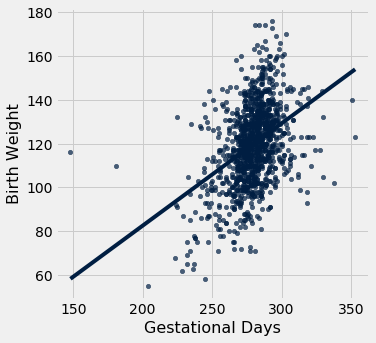

In [34]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [35]:
slope(births, 'Gestational Days', 'Birth Weight')

0.4665568769492152

In [36]:
slopes = make_array()
for i in np.arange(2500):
    bootstrap_sample = births.sample()
    bootstrap_slope = slope(bootstrap_sample, 'Gestational Days', 'Birth Weight')
    slopes = np.append(slopes, bootstrap_slope)

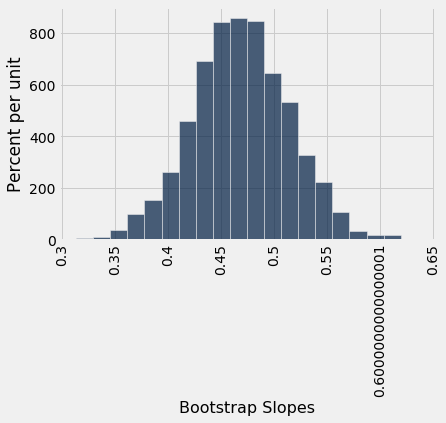

In [37]:
Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)

In [38]:
left = percentile(2.5, slopes)
right = percentile(97.5, slopes)
left, right

(0.3774915266178529, 0.5579491079419944)

In [39]:
def bootstrap_slope(t, x, y, repetitions=5000):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

Slope of regression line: 0.4665568769492152
Approximate 95%-confidence interval for the slope of the true line:
0.3789803338260356 to 0.5557084664077788


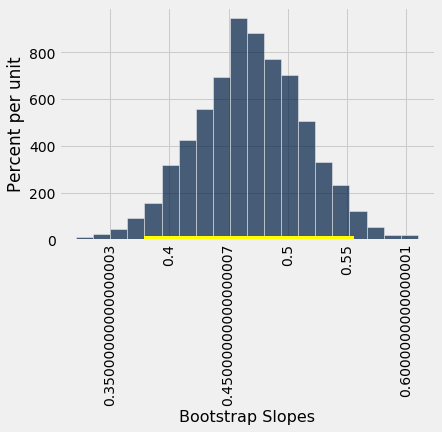

In [40]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight', 2500)

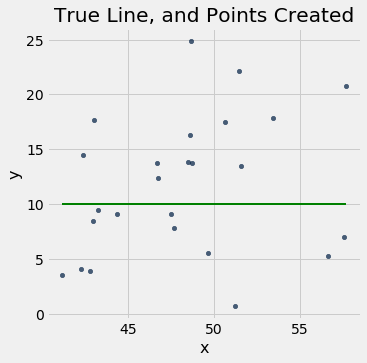

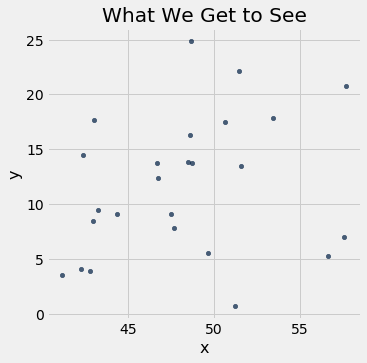

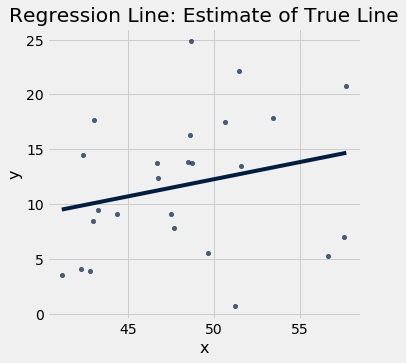

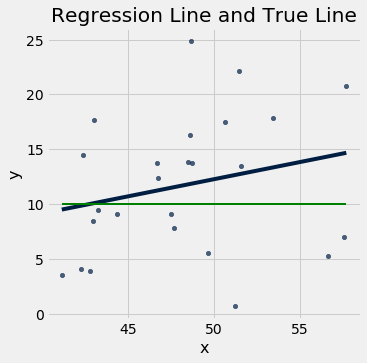

In [41]:
draw_and_compare(0, 10, 25)

**Null Hypothesis.** Slope of true line = 0.

**Alternative Hypothesis.** Slope of true line is not 0.

In [42]:
slope(births, 'Maternal Age', 'Birth Weight')

0.08500766941582513

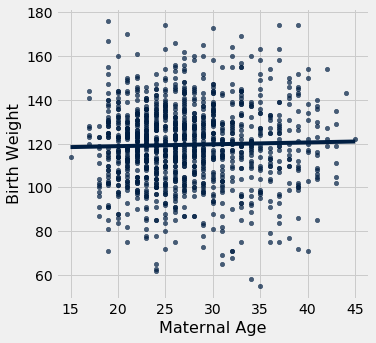

In [43]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

Slope of regression line: 0.08500766941582513
Approximate 95%-confidence interval for the slope of the true line:
-0.10358121866338342 to 0.2749885522546859


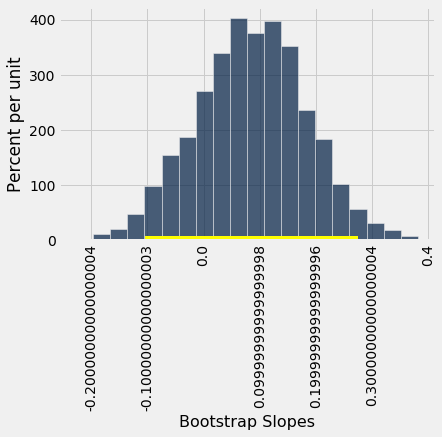

In [44]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight', 2500)